In [58]:
from pathlib import Path
from pprint import pformat
import sys
import os
from os.path import join, exists, isfile
from os import makedirs

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

import cv2
import tqdm

## Preprocess data

In [59]:
data_folder = "office1"

dataset = Path(f'../datasets/{data_folder}/')  # change this if your dataset is somewhere else
images = Path(f'../datasets/{data_folder}/images')

outputs = Path(f'../outputs/{data_folder}/')  # where everything will be saved
# results = outputs / 'InLoc_hloc_superpoint+superglue_netvlad40.txt'  # the result file

# loc_pairs = outputs / 'pairs-query.txt'  # top 40 retrieved by NetVLAD
# features = outputs / 'features.h5'
# matches = outputs / 'matches.h5'

references = [p.relative_to(images).as_posix() for p in (images / 'mapping/').iterdir()]
queries = [p.relative_to(images).as_posix() for p in (images / 'query/').iterdir()]

In [60]:
# Create a imagenames txt file for db images
with open(str(dataset / "imageNames_db.txt"), "w") as file:
    for r in references:
        file.write(f'../../datasets/{data_folder}/images/'+r+'\n')
        
# Create a imagenames txt file for query images
with open(str(dataset / "imageNames_query.txt"), "w") as file:
    for q in queries:
        file.write(f'../../datasets/{data_folder}/images/'+q+'\n')

In [61]:
# Create output directories
Path(f'../outputs/{data_folder}/output_features/{data_folder}_db').mkdir(parents=True, exist_ok=True)
Path(f'../outputs/{data_folder}/output_features/{data_folder}_query').mkdir(parents=True, exist_ok=True)
Path(f'../outputs/{data_folder}/results').mkdir(parents=True, exist_ok=True)
Path(f'../outputs/{data_folder}/inlier_indices/db').mkdir(parents=True, exist_ok=True)
Path(f'../outputs/{data_folder}/inlier_indices/query').mkdir(parents=True, exist_ok=True)

## Feature extraction

In [62]:
# PatchNetVLAD commands

# DB feature extraction
os.system(f"python3 ../third_party/PatchNetVLAD/feature_extract.py \
  --config_path ../third_party/PatchNetVLAD/patchnetvlad/configs/performance.ini \
  --dataset_file_path=../datasets/{data_folder}/imageNames_db.txt \
  --dataset_root_dir=../datasets/{data_folder}/ \
  --output_features_dir ../outputs/{data_folder}/output_features/{data_folder}_db") 


# Query feature extraction
os.system(f"python3 ../third_party/PatchNetVLAD/feature_extract.py \
  --config_path ../third_party/PatchNetVLAD/patchnetvlad/configs/performance.ini \
  --dataset_file_path=../datasets/{data_folder}/imageNames_query.txt \
  --dataset_root_dir=../datasets/{data_folder}/ \
  --output_features_dir ../outputs/{data_folder}/output_features/{data_folder}_query") 

Namespace(config_path='../third_party/PatchNetVLAD/patchnetvlad/configs/performance.ini', dataset_file_path='../datasets/office1/imageNames_db.txt', dataset_root_dir='../datasets/office1/', nocuda=False, output_features_dir='../outputs/office1/output_features/office1_db')
Parsing dataset...
Done! Found 15 images
=> loading checkpoint '/app/third_party/PatchNetVLAD/patchnetvlad/./pretrained_models/mapillary_WPCA4096.pth.tar'
=> loaded checkpoint '/app/third_party/PatchNetVLAD/patchnetvlad/./pretrained_models/mapillary_WPCA4096.pth.tar'
====> Extracting Features



      Test Iter:   0%|          | 0/3 [00:00<?, ?it/s]
                                                      Traceback (most recent call last):
  File "../third_party/PatchNetVLAD/feature_extract.py", line 182, in <module>
    main()
  File "../third_party/PatchNetVLAD/feature_extract.py", line 174, in main
    feature_extract(dataset, model, device, opt, config)
  File "../third_party/PatchNetVLAD/feature_extract.py", line 77, in feature_extract
    vlad_local, vlad_global = model.pool(image_encoding)
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/app/third_party/PatchNetVLAD/patchnetvlad/models/patchnetvlad.py", line 182, in forward
    vladflattened.append(get_square_regions_from_integral(ivlad, int(patch_size), int(stride)))
  File "/app/third_party/PatchNetVLAD/patchnetvlad/models/patchnetvlad.py", line 68, in get_square_regions_from_integral
    feat_regions = torch.nn.functi

Namespace(config_path='../third_party/PatchNetVLAD/patchnetvlad/configs/performance.ini', dataset_file_path='../datasets/office1/imageNames_query.txt', dataset_root_dir='../datasets/office1/', nocuda=False, output_features_dir='../outputs/office1/output_features/office1_query')
Parsing dataset...
Done! Found 10 images
=> loading checkpoint '/app/third_party/PatchNetVLAD/patchnetvlad/./pretrained_models/mapillary_WPCA4096.pth.tar'
=> loaded checkpoint '/app/third_party/PatchNetVLAD/patchnetvlad/./pretrained_models/mapillary_WPCA4096.pth.tar'
====> Extracting Features



      Test Iter:   0%|          | 0/2 [00:00<?, ?it/s]
                                                      Traceback (most recent call last):
  File "../third_party/PatchNetVLAD/feature_extract.py", line 182, in <module>
    main()
  File "../third_party/PatchNetVLAD/feature_extract.py", line 174, in main
    feature_extract(dataset, model, device, opt, config)
  File "../third_party/PatchNetVLAD/feature_extract.py", line 77, in feature_extract
    vlad_local, vlad_global = model.pool(image_encoding)
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/app/third_party/PatchNetVLAD/patchnetvlad/models/patchnetvlad.py", line 182, in forward
    vladflattened.append(get_square_regions_from_integral(ivlad, int(patch_size), int(stride)))
  File "/app/third_party/PatchNetVLAD/patchnetvlad/models/patchnetvlad.py", line 68, in get_square_regions_from_integral
    feat_regions = torch.nn.functi

256

## Feature matching

In [63]:
# Feature matching
os.system(f"python3 ../third_party/PatchNetVLAD/feature_match.py \
  --config_path ../third_party/PatchNetVLAD/patchnetvlad/configs/performance.ini \
  --dataset_root_dir=../datasets/{data_folder}/ \
  --query_file_path=../datasets/{data_folder}/imageNames_query.txt \
  --index_file_path=../datasets/{data_folder}/imageNames_db.txt \
  --query_input_features_dir ../outputs/{data_folder}/output_features/{data_folder}_query \
  --index_input_features_dir ../outputs/{data_folder}/output_features/{data_folder}_db \
  --result_save_folder ../outputs/{data_folder}/results") 

Namespace(config_path='../third_party/PatchNetVLAD/patchnetvlad/configs/performance.ini', dataset_root_dir='../datasets/office1/', ground_truth_path=None, index_file_path='../datasets/office1/imageNames_db.txt', index_input_features_dir='../outputs/office1/output_features/office1_db', nocuda=False, query_file_path='../datasets/office1/imageNames_query.txt', query_input_features_dir='../outputs/office1/output_features/office1_query', result_save_folder='../outputs/office1/results')
Parsing dataset...
Done! Found 10 images
Parsing dataset...
Done! Found 15 images


Traceback (most recent call last):
  File "../third_party/PatchNetVLAD/feature_match.py", line 213, in <module>
    main()
  File "../third_party/PatchNetVLAD/feature_match.py", line 205, in main
    feature_match(dataset, device, opt, config)
  File "../third_party/PatchNetVLAD/feature_match.py", line 107, in feature_match
    qFeat = np.load(input_query_global_features_prefix)
  File "/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py", line 405, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
FileNotFoundError: [Errno 2] No such file or directory: '../outputs/office1/output_features/office1_query/globalfeats.npy'


256

## Visualize results

In [56]:
def parse_results(output_path):
    img_pairs = {}
    
    result_path = output_path + '/results/PatchNetVLAD_predictions.txt' 

    with open(result_path) as file:
        for line in file:
            if not line.__contains__("#"):
                t = line.rstrip()
                t = t.split(", ")
                
                q_name = t[0].split("/")[-1]#.replace(".jpeg", "")
                q_name = os.path.splitext(q_name)[0]
                q_name_ext = t[0].split("/")[-1]
                q_path = t[0]
                q_inlier_path = f'{output_path}/inlier_indices/query/inlier_indices_{q_name}.npy'
                db_inlier_path = f'{output_path}/inlier_indices/db/inlier_indices_{q_name}.npy'
                
                if q_name not in img_pairs:
                    img_pairs[q_name] = { "name": q_name, 
                                          "name_ext": q_name_ext, 
                                          "path": q_path, 
                                          "inlier_path": q_inlier_path, 
                                          "db_inlier_path": db_inlier_path,
                                          "db": [] }
                
                db_name = t[1].split("/")[-1].replace(".jpeg", "")
                db_name_ext = t[1].split("/")[-1]
                db_path = t[1] 
                
                img_pairs[q_name]["db"].append({"name": db_name, 
                                                "name_ext": db_name_ext, 
                                                "path": db_path })

                
    return img_pairs

def get_inliers(query_data):
    all_query_inliers = []
    all_db_inliers = []
    
    q_inlier_path = query_data["inlier_path"]
    q_inliers = np.load(q_inlier_path, allow_pickle=True)
    db_inlier_path = query_data["db_inlier_path"]
    db_inliers = np.load(db_inlier_path, allow_pickle=True)
    
    db_imgs = query_data["db"]
    
    for i in range(len(db_imgs)):
        img_idx = int(db_imgs[i]["name"].split("_")[-1])
        temp_q_inliers = []
        temp_db_inliers = []
        for j in range(np.array(db_inliers[i], dtype=object).shape[0]): 
            #if j <= len(q_inliers[i]):
            temp_db_inliers.append(db_inliers[i][j])
        
        for j in range(len(temp_db_inliers)):
            temp_q_inliers.append(q_inliers[i][j])

        all_query_inliers.append(np.array(temp_q_inliers, dtype=object))
        all_db_inliers.append(np.array(temp_db_inliers, dtype=object))
        
    return np.array(all_query_inliers, dtype=object), np.array(all_db_inliers, dtype=object)

def convert_values_to_new_interval(prev_height, prev_width, new_height, new_width, points):
    new_points = []
    for p in points:
        new_p = np.array([int((p[1] / prev_height) * new_height), int((p[0] / prev_width) * new_width)])
        new_points.append(new_p)
    
    return np.array(new_points)

def add_patches_to_fig(q_in, db_in, q_patches, db_patches, q_ax, db_ax):
    
    patch_colors = ["r", "c", "g"]
    for i in range(len(q_in)):
        for j in range(len(q_in[i])):
            kp = q_in[i][j]
            rect = patches.Rectangle((kp[1]-(q_patches[i][1]/2), kp[0]-(q_patches[i][0]/2)), 
                                     q_patches[i][1], 
                                     q_patches[i][0], 
                                     linewidth=1, 
                                     edgecolor=patch_colors[i], 
                                     facecolor='none')

            # Add the patch to the Axes
            q_ax.add_patch(rect)
            
            
    for i in range(len(db_in)):
        for j in range(len(db_in[i])):
            kp = db_in[i][j]
            rect = patches.Rectangle((kp[1]-(db_patches[i][1]/2), kp[0]-(db_patches[i][0]/2)), 
                                     db_patches[i][1], 
                                     db_patches[i][0], 
                                     linewidth=1, 
                                     edgecolor=patch_colors[i], 
                                     facecolor='none')

            # Add the patch to the Axes
            db_ax.add_patch(rect)
            
    return q_ax, db_ax

def add_lines_to_fig(q_in, db_in, q_ax, db_ax):
    xyAs, xyBs= [], []
    line_colors = ["red", "cyan", "green"]
    
    for i in range(len(q_in)):
        temp_A=[]
        for j in range(len(q_in[i])):
            kp = q_in[i][j]
            temp_A.append([kp[1], kp[0]])
            
        xyAs.append(temp_A)
        
    for i in range(len(db_in)):
        temp_B=[]
        for j in range(len(db_in[i])):
            kp = db_in[i][j]
            temp_B.append([kp[1], kp[0]])
            
        xyBs.append(temp_B)
        
    for i in range(len(xyAs)):
        xypA = xyAs[i]
        xypB = xyBs[i]
        
        for j, xy in enumerate(xypA):
            con = ConnectionPatch(linewidth=0.5, 
                                  xyA=xy, 
                                  xyB=xypB[j], 
                                  coordsA="data",
                                  coordsB="data",
                                  axesA=q_ax, 
                                  axesB=db_ax, 
                                  color=line_colors[i])
            db_ax.add_artist(con)
        
    return q_ax, db_ax
        


def plot_figures(q_img, q_img_name, db_img, db_img_name, q_in, db_in, q_patches, db_patches):
    fig, axs = plt.subplots(1,2, figsize=(8, 6))

    axs[0].set_title(q_img_name, fontsize=8)
    axs[0].imshow(q_img)
    
    scatter_col = ["r", "c", "g"]
    
    for i in range(len(q_in)):
        axs[0].scatter(q_in[i][:,1], q_in[i][:,0], marker="o", c=scatter_col[i], s=2)
    
    axs[1].set_title(db_img_name, fontsize=8)
    axs[1].imshow(db_img)
    
    for i in range(len(db_in)):
        axs[1].scatter(db_in[i][:,1], db_in[i][:,0], marker="o", c=scatter_col[i], s=2)
        
        
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    plt.tight_layout()
        
    axs[0], axs[1] = add_patches_to_fig(q_in=q_in,
                                        db_in=db_in, 
                                        q_patches=q_patches, 
                                        db_patches=db_patches, 
                                        q_ax=axs[0], 
                                        db_ax=axs[1])
    axs[0], axs[1] = add_lines_to_fig(q_in=q_in, 
                                      db_in=db_in, 
                                      q_ax=axs[0], 
                                      db_ax=axs[1])
    
    pass
    

100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.93it/s]


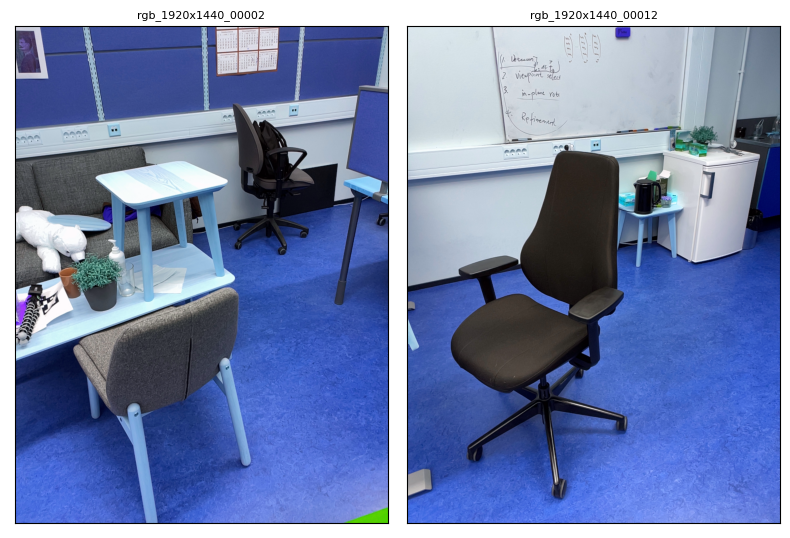

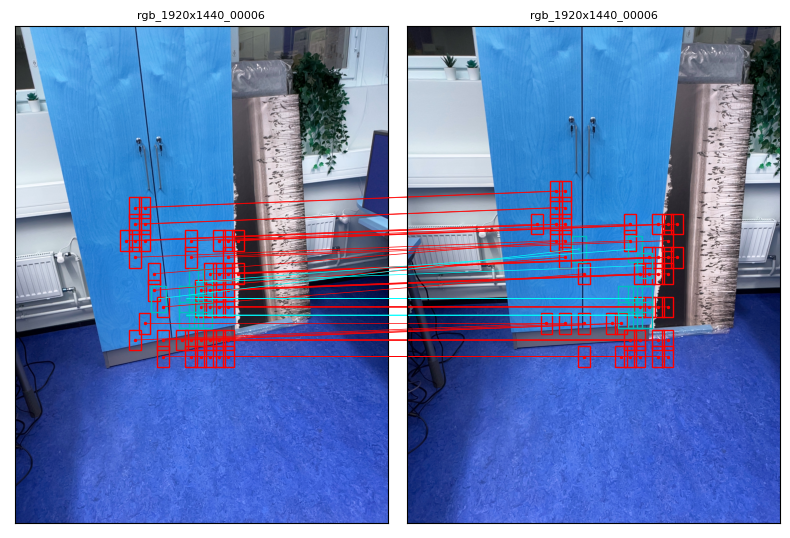

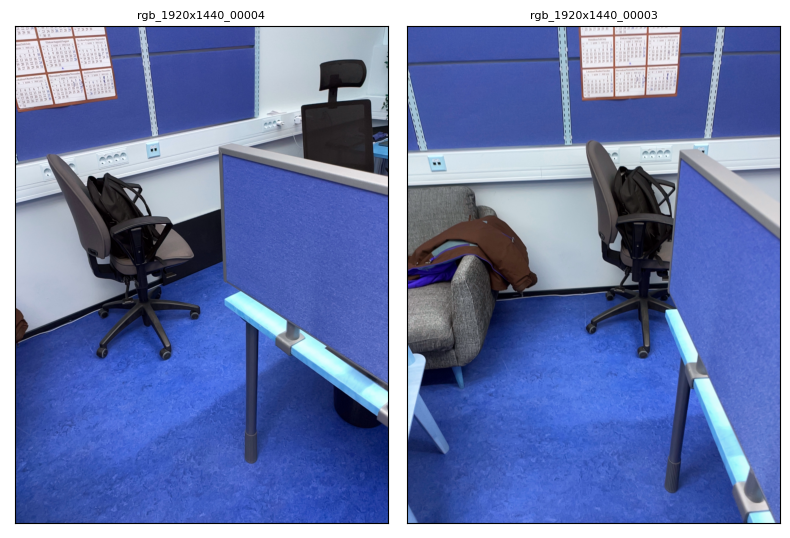

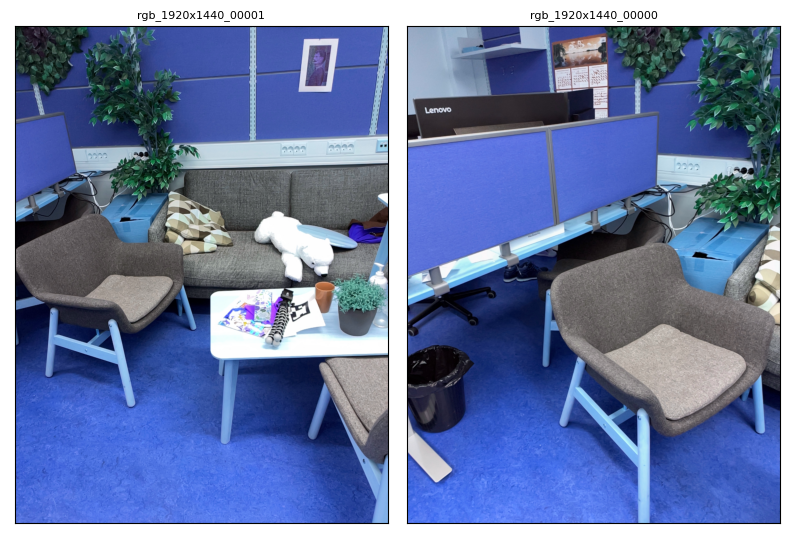

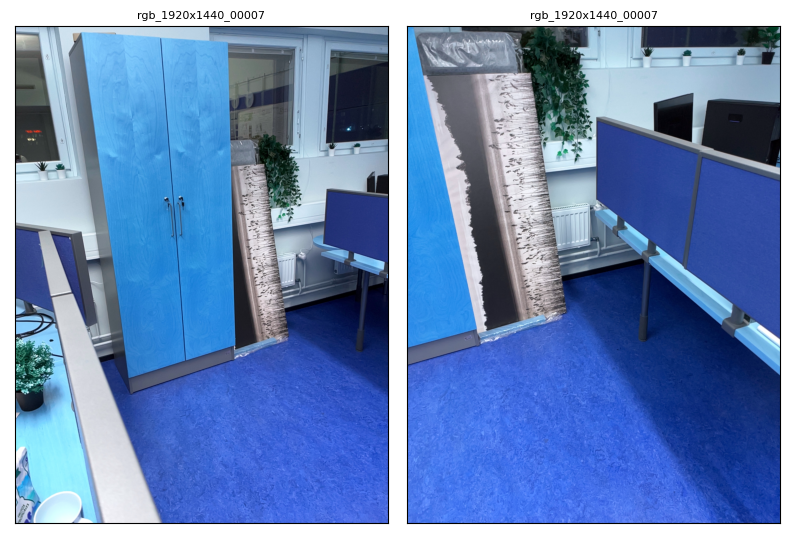

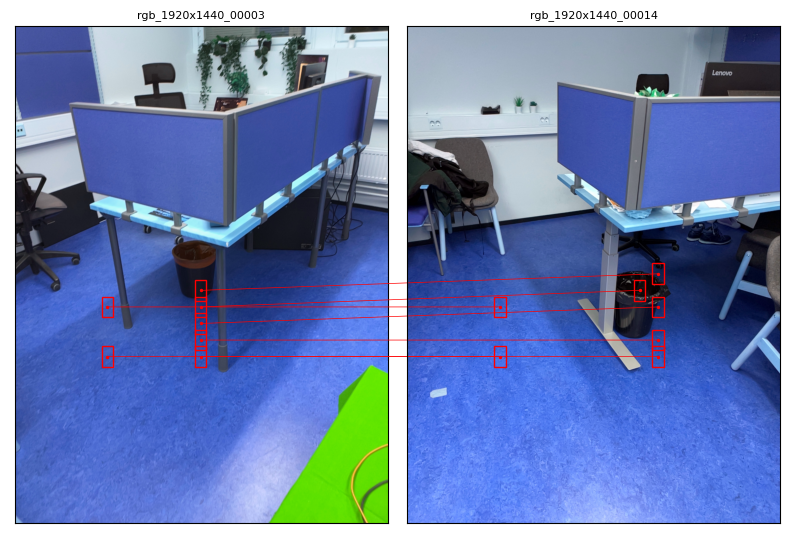

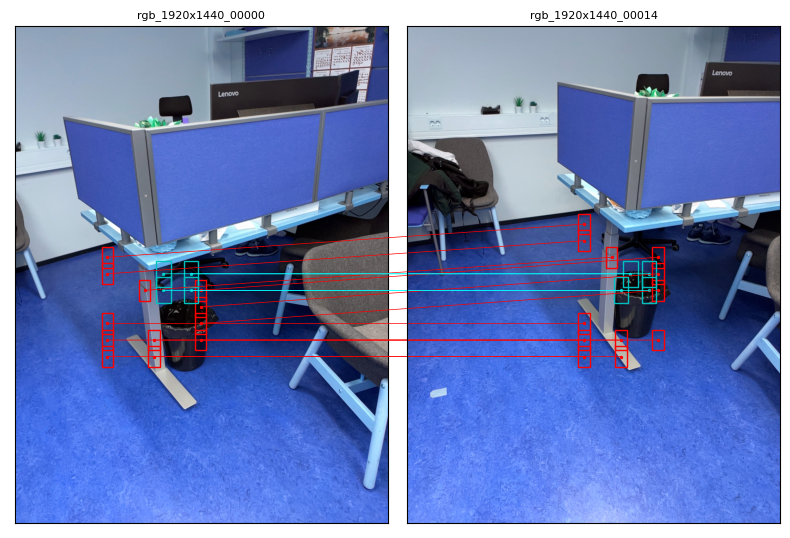

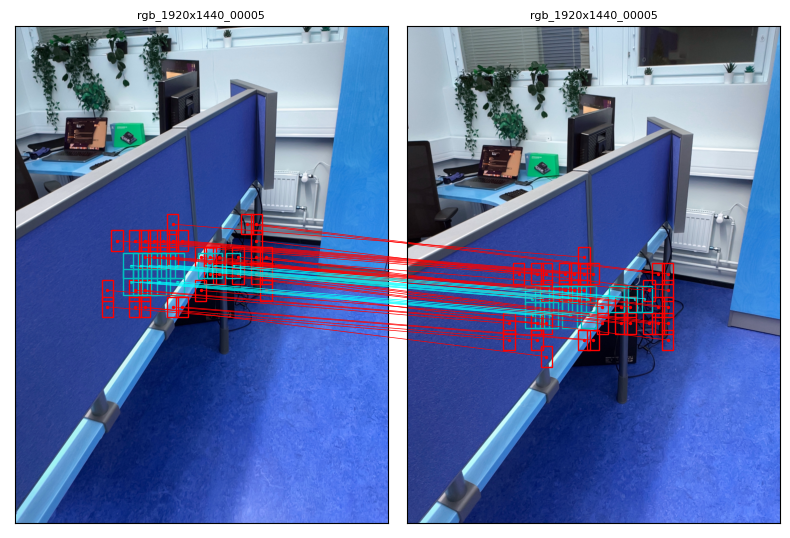

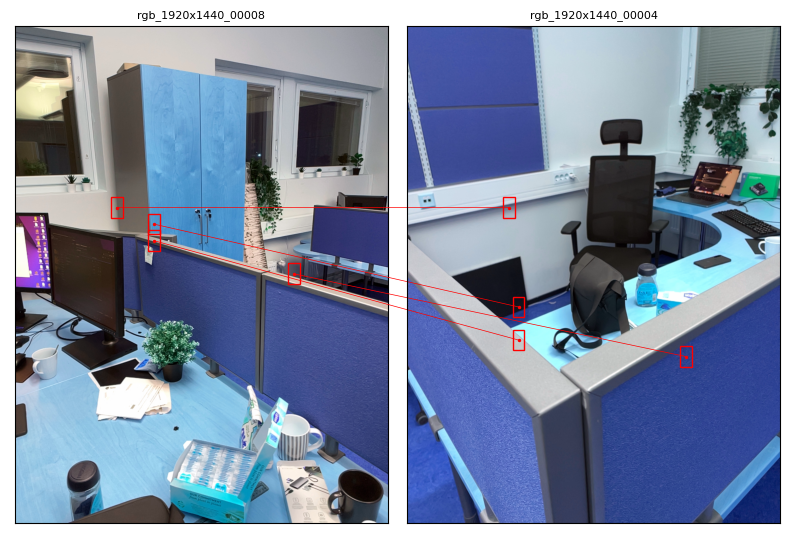

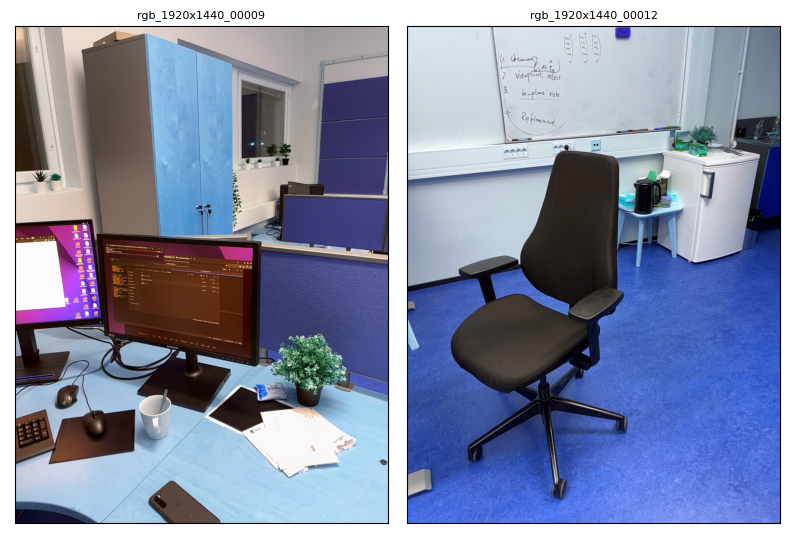

In [57]:
patch1 = (20,20)
patch2 = (25,25)
patch3 = (28,28)

pnv_height, pnv_width = 480, 640 # PatchNetVLAD resizes all the images to (480, 640) shape

query_results = parse_results(f'../outputs/{data_folder}')

show_number_of_results = 1

for key, query_data in tqdm.tqdm(query_results.items()):
    
    # read query image
    q_img = cv2.imread(query_data["path"])
    q_height, q_width, _ = q_img.shape
    
    q_inliers, db_inliers = get_inliers(query_data)
    
    q_p1, q_p2, q_p3 = convert_values_to_new_interval(pnv_height, pnv_width, q_height, q_width, [patch1, patch2, patch3])
    
    for i, db in enumerate(query_data["db"][:show_number_of_results]):
        q_in = q_inliers[i]
        db_in = db_inliers[i]
        
        db_img = cv2.imread(db["path"])
        db_height, db_width, _ = db_img.shape
        
        db_p1, db_p2, db_p3 = convert_values_to_new_interval(pnv_height, pnv_width, db_height, db_width, [patch1, patch2, patch3])
        resized_q_in = []
        resized_db_in = []
        
        for j in range(len(q_in)):
            if np.array(q_in[j]).shape[0] > 0 and np.array(db_in[j]).shape[0] > 0:
                resized_q_in.append(convert_values_to_new_interval(pnv_height, pnv_width, q_height, q_width, q_in[j]))
                resized_db_in.append(convert_values_to_new_interval(pnv_height, pnv_width, db_height, db_width, db_in[j]))
            
        plot_figures(q_img=q_img, 
                     q_img_name=query_data["name"], 
                     db_img=db_img, 
                     db_img_name=db["name"], 
                     q_in=resized_q_in, 
                     db_in=resized_db_in, 
                     q_patches=[q_p1, q_p2, q_p3], 
                     db_patches=[db_p1, db_p2, db_p3])
            